# Mimicking apathy: 

Learning MNIST as normal, then swapping the labels for 2 digits while decreasing the magnitude of the error signals

--> the network cannot adapt to new informations and to its environment. 


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from skimage.metrics import structural_similarity as ssim

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Dataset

In [3]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [160]:
from modules.network import PV_SST_Pyr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10, swap_digits=(5,6)).to(device)

print(model)
print(f"Model swap_digits: {model.swap_digits}")

PV_SST_Pyr(
  (encoder): encoder(
    (flatten): Flatten()
    (activation): Sigmoid()
    (fc1): Linear(in_features=784, out_features=32, bias=True)
  )
  (decoder): decoder(
    (activation): Sigmoid()
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=784, bias=True)
  )
  (classifier): classifier(
    (fc1): Linear(in_features=32, out_features=10, bias=True)
    (activation): Sigmoid()
  )
)
Model swap_digits: (5, 6)


In [161]:
for name, param in model.named_parameters():
    print (name)   

encoder.fc1.weight
encoder.fc1.bias
decoder.fc1.weight
decoder.fc1.bias
decoder.fc2.weight
decoder.fc2.bias
classifier.fc1.weight
classifier.fc1.bias


### Train & test

In [162]:
def successive_learning(epoch, model):
    if epoch is not None:
        if (epoch <= 70): # unsupervised learning ONLY at the beginning of the learning
            model.freeze_module('classifier')
            return 1, 2 # alpha, lr
        elif epoch > 70: # unsupervised learning + classification after some epochs
            model.unfreeze_module('classifier')
            return 0.5, 0.05
    else:
        model.freeze_module('classifier')
        return 1, 2

In [163]:
def calculate_multiple_accuracy(targets, output, total, correct):
    _, predicted = output.max(1)
    # Iterate through the targets and predictions
    for digit in range(10):
        # Create a mask for the current digit
        mask = (targets == digit)

        # Update total count for the current digit
        total[digit] += mask.sum().item()

        # Update correct count for the current digit
        correct[digit] += (predicted[mask] == targets[mask]).sum().item()

In [164]:
lr = 0.05
momentum = 0.5
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 250
log_interval = 400
alpha = 1 
lr = 2

train_losses, train_recon_losses, train_global_losses  = [], [], []
train_ssim, train_acc = [], []
train_counter = []
test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

swap_epoch = 140

In [165]:
from modules.utils import weight_update, compute_losses 
from modules.utils import swap_digits
from modules.utils import compute_scale_factor, scaled_backard
from modules.metrics import plot_digits, visualize_tsne, calculate_ssim
from modules.metrics import tsne_and_clustering, plot_digits_and_saliency
from modules.utils import weight_update
# from modules.utils import successive_learning
#from modules.metrics import calculate_multiple_accuracy

def train(epoch, dataloader, model, optimizer, loss_fn, alpha):
    recon_loss_avg, global_loss_avg, loss_avg = 0,0,0
    total, correct, accuracy = {i: 0 for i in range(10)}, {i: 0 for i in range(10)}, {}
    model.train() 
    if model.swap_digits is None: 
        raise ValueError("Needs digits whose labels to swap")
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        thal_input, target = batch 
        _, recon, output = model(thal_input)

        # Successive learning dynamics for the first 140 epochs (no "if statement" bc already implemented in the function)
        alpha, lr = successive_learning(epoch, model)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        # Swap digits after basic training (140 epochs)
        if epoch <= swap_epoch:
            t = F.one_hot(target, num_classes=10).float()
            recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)
            weight_update(model, optimizer, recon_loss, global_loss, total_loss)
        elif epoch > swap_epoch:
            recon_loss, global_loss, total_loss = swap_digits(model, target, recon, thal_input, output, loss_fn, alpha)
            scale_factor = compute_scale_factor(epoch, swap_epoch) # decreasing the magnitude of the error signal
            weight_update(model, optimizer, recon_loss, global_loss, total_loss)
            scaled_backard(model, scale_factor) 
        calculate_multiple_accuracy(target, output, total, correct) #TODO: with the modified targets
        optimizer.step()
        optimizer.zero_grad()

        recon_loss_avg += recon_loss.item()
        global_loss_avg += global_loss.item()
        loss_avg += total_loss.item()       
       
        if batch_idx % log_interval == 0:
            train_losses.append(total_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_global_losses.append(global_loss.item())
            train_ssim.append(calculate_ssim(recon, thal_input))
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))

    for digit in range(10):
        accuracy[digit] = (correct[digit] / total[digit] * 100) if total[digit] > 0 else float('nan')
    recon_loss_avg, global_loss_avg, loss_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, loss_avg))
    print('Epoch: {} Recon_loss: {:.6f} Global_loss: {:.6f} Total loss: {:.6f}'.format(
        epoch, recon_loss_avg, global_loss_avg, loss_avg))
    train_acc.append(accuracy)
    #print('Accuracy train: {}'.format(accuracy))

    

In [166]:
def test(dataloader, model, loss_fn, alpha, epoch=None):
    model.eval()
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg = 0,0,0,0
    encoded_outputs = []
    labels = []
    total, correct, accuracy = {i: 0 for i in range(10)}, {i: 0 for i in range(10)}, {}
    with torch.no_grad():
        for batch in dataloader:
            thal_input, target = batch
            t = F.one_hot(target, num_classes=10).float()
            encoded, recon, output = model(thal_input)

            # Successive learning dynamics for the first 140 epochs
            alpha, _ = successive_learning(epoch, model)

            # NO Swap digits: we want to assess the losses and metrics with the right labels
            recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)


            ssim_avg += calculate_ssim(recon, thal_input)
            calculate_multiple_accuracy(target, output, total, correct)
            recon_loss_avg += recon_loss.item()
            global_loss_avg += global_loss.item()
            test_loss_avg += total_loss.item()
            encoded_outputs.append(encoded)
            labels.append(target)

            
                  
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg))
    test_ssim.append(ssim_avg)
    test_losses.append(test_loss_avg)
    encoded_outputs = torch.cat(encoded_outputs)
    labels = torch.cat(labels)
    if epoch is None or (epoch is not None and epoch % 10 == 0):
            visualize_tsne(encoded_outputs, labels, epoch)
            plot_digits(model, dataloader, n=5,swap_argument=None, epoch=epoch)
            #silhouette_score = tsne_and_clustering(encoded_outputs, labels, epoch)
            #test_silhouette.append(silhouette_score)
            #plot_digits_and_saliency(model, dataloader, n=5,swap_argument=None, epoch=epoch)
            #print('Silhouette score: {}'.format(silhouette_score))
    for digit in range(10):
        accuracy[digit] = (correct[digit] / total[digit] * 100) if total[digit] > 0 else float('nan')
    test_acc.append(accuracy)
    print('Test set: Recon_loss: {:.6f} Global_loss: {:.6f}  SSIM {:.6f}'.format(
        recon_loss_avg, global_loss_avg, ssim_avg))
    print('Accuracy test: {} \n, mean {}: \n'.format(accuracy, np.mean(list(accuracy.values()))))

In [167]:
test(test_data_loader, model, loss_fn, alpha)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, optimizer, loss_fn, alpha)
  test(test_data_loader, model, loss_fn, alpha, epoch)

Test set: Recon_loss: 1.269771 Global_loss: 0.249665  SSIM -0.033481
Accuracy test: {0: 0.0, 1: 0.0, 2: 0.0, 3: 33.069306930693074, 4: 0.0, 5: 0.0, 6: 0.0, 7: 98.24902723735408, 8: 0.0, 9: 1.0901883052527255} 
, mean 13.240852247329988: 

Epoch: 1 Recon_loss: 0.824038 Global_loss: 0.245867 Total loss: 0.824038
Test set: Recon_loss: 0.808126 Global_loss: 0.246300  SSIM 0.029608
Accuracy test: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 100.0, 8: 0.0, 9: 0.0} 
, mean 10.0: 

Epoch: 2 Recon_loss: 0.803271 Global_loss: 0.244376 Total loss: 0.803271
Test set: Recon_loss: 0.805872 Global_loss: 0.242911  SSIM 0.030371
Accuracy test: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 99.70817120622569, 8: 0.0, 9: 0.0} 
, mean 9.970817120622568: 

Epoch: 3 Recon_loss: 0.800863 Global_loss: 0.244317 Total loss: 0.800863
Test set: Recon_loss: 0.803730 Global_loss: 0.245566  SSIM 0.030709
Accuracy test: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.11210762331838565, 6: 0.

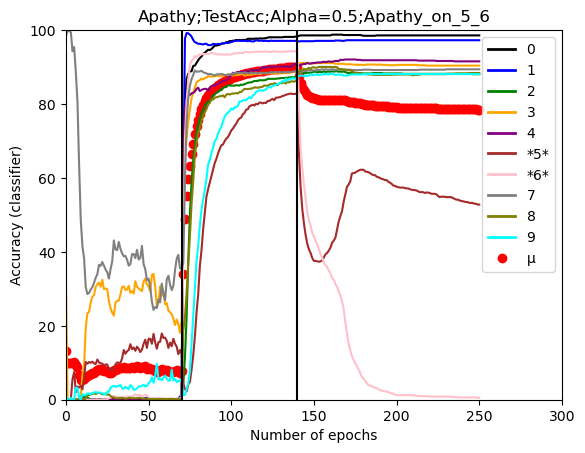

In [176]:
import matplotlib.pyplot as plt
digit_x, digit_y = model.swap_digits

colors = ['black', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
labels = [f'{i}' for i in range(10)]

fig = plt.figure()
for i in range(10):
    plt.plot(range(num_epochs+1), [epoch_acc[i] for epoch_acc in test_acc], color=colors[i])
plt.scatter(range(num_epochs+1), [np.mean(list(i.values())) for i in test_acc], color='red')

legend_labels = []
for i, label in enumerate(labels):
    if i == digit_x or i == digit_y:
        # show the swapped digits
        legend_labels.append(f'*{label}*')
    else:
        legend_labels.append(label)
legend_labels.append('μ')

legend_handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors]
legend_handles.append(plt.Line2D([0], [0], marker='o', color='red', lw=0, markerfacecolor='red'))

plt.legend(legend_handles, legend_labels, loc='upper right')
plt.vlines(70,0, 100, color='black')
plt.vlines(140,0, 100, color='black')

plt.xlabel('Number of epochs')
plt.xlim([0, num_epochs + 50])
plt.ylim([0, 100])
plt.ylabel('Accuracy (classifier)')
plt.title(f"Apathy;TestAcc;Alpha=0.5;Apathy_on_{digit_x}_{digit_y}")
#plt.savefig(f'./Plots/Accuracies/Apathy;TestAcc;Diff_learning;Alpha=0.5;{digit_x}-{digit_y}.png', dpi=300, bbox_inches='tight')
plt.show()

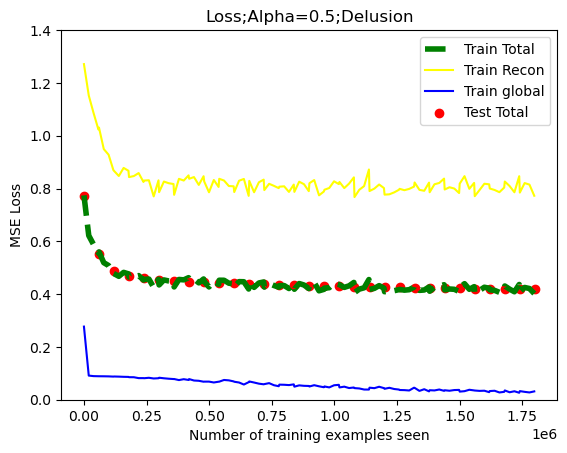

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green', linestyle= 'dashed', linewidth = 4)
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train global', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 1.4])
plt.ylabel('MSE Loss')
plt.title("Loss;Alpha=0.5;Delusion")
plt.savefig('./Plots/Delusion/Loss;Alpha=0.5;Delusion.png', dpi=300, bbox_inches='tight')
plt.show()

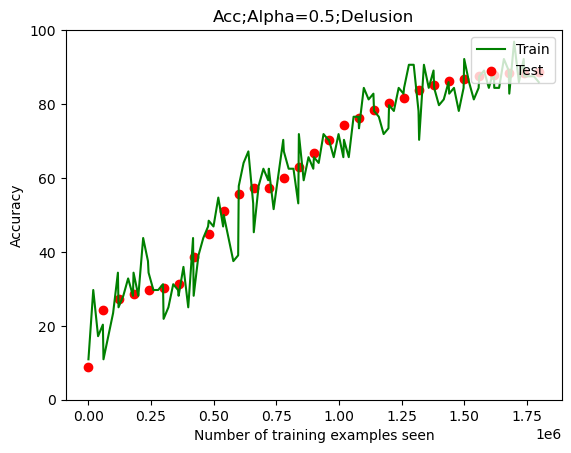

In [ ]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_acc, color='green')
plt.scatter(test_counter, test_acc, color='red')
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 100])
plt.ylabel('Accuracy')
plt.title("Acc;Alpha=0.5;Delusion")
plt.savefig('./Plots/Delusion/Acc;Alpha=0.5;Delusion.png', dpi=300, bbox_inches='tight')
plt.show()

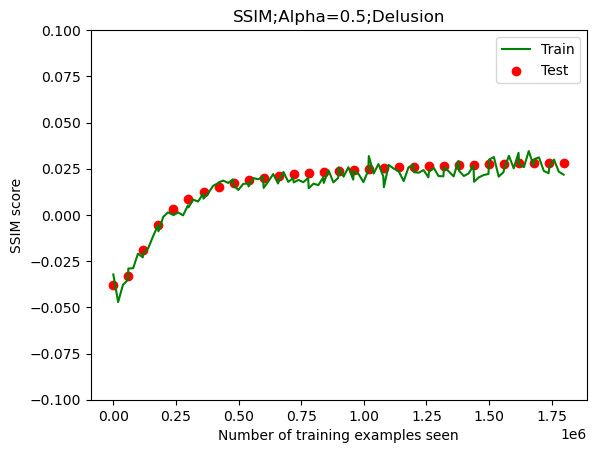

In [ ]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_ssim, color='green')
plt.scatter(test_counter, test_ssim, color='red')
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([-0.1, 0.1])
plt.ylabel('SSIM score')
plt.title("SSIM;Alpha=0.5;Delusion")
plt.savefig('./Plots/Delusion/SSIM;Alpha=0.5;Delusion.png', dpi=300, bbox_inches='tight')
plt.show()
